# Tarefa 1 - Classificador CART
## Importar Bibliotecas

In [185]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

O data set é gerado direto pelo arquivo gerar_dados_vitimas.py disponibilizado pelo professor (único parâmetro alterado foi o número de vítimas)

In [186]:
df_treino = pd.read_csv('datasets/vict/10v/data.csv')
print(f"Dataset com {len(df_treino)} vítimas")
print(df_treino.head())
X = df_treino.iloc[:, 0:10].values   # colunas 1 a 10
y = df_treino["tri"].values          # coluna 13
print(X)

Dataset com 800 vítimas
   idade   fc  fr  pas  spo2       temp  pr  sg  fx  queim  gcs  avpu  tri  \
0     21    0   0    0    17  26.291506   0   3   0      0    3     3    3   
1     21  109  25   96    93  37.353475   1   1   0      0   13     1    1   
2     30  102  26   96    92  37.708092   0   1   1      0   13     0    1   
3     18    2   0    0    37  27.775682   0   3   0      3    3     3    3   
4     23   95  18  114    98  36.894670   1   0   1      0   15     0    0   

   sobr  
0  0.22  
1  0.92  
2  0.86  
3  0.24  
4  0.98  
[[ 21.   0.   0. ...   3.   0.   0.]
 [ 21. 109.  25. ...   1.   0.   0.]
 [ 30. 102.  26. ...   1.   1.   0.]
 ...
 [ 27.   4.   1. ...   3.   0.   0.]
 [ 17. 126.  44. ...   3.   1.   0.]
 [ 22.  77.  11. ...   0.   1.   0.]]


## Divisão de Dataset de Treino (75%) e Teste(25%)

In [187]:
## Dividir o dataset em treinamento/validação e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, shuffle=True)
print(f"Tamanho total do dataset: {len(X)}\n")
print(f"Dados de treinamento X ({len(X_treino)}):\n{X_treino[:3]} ...")
print(f"Dados de treinamento y:({len(y_treino)})\n {y_treino[:3]} ...")
print("---")
print(f"Dados de teste   X ({len(X_teste)}):\n{X_teste[:3]} ...")
print(f"Dados de teste   y:({len(y_teste)})\n {y_teste[:3]} ...")

Tamanho total do dataset: 800

Dados de treinamento X (600):
[[ 31.         108.          23.         102.          94.
   38.48686997   1.           2.           1.           0.        ]
 [ 22.         107.          28.          93.          94.
   37.76685195   1.           1.           1.           0.        ]
 [ 24.          97.          24.         109.          94.
   37.05281098   1.           1.           0.           1.        ]] ...
Dados de treinamento y:(600)
 [1 1 1] ...
---
Dados de teste   X (200):
[[ 23.         120.          43.          76.          83.
   34.08779649   0.           3.           1.           3.        ]
 [ 27.           0.           1.           1.          16.
   28.47713609   0.           3.           0.           3.        ]
 [ 26.          84.          18.         111.          96.
   36.49329474   1.           0.           1.           0.        ]] ...
Dados de teste   y:(200)
 [2 3 0] ...


## Teste de parâmetros

Leaf Range abaixo de 0.23 sempre da o mesmo resultado, quanto mais maior a porcentaggem

In [188]:
from itertools import product

# Gerador de parâmetros para teste
depth_range = [5, 2, 1]  # profundidade de 1 a 200
leaf_range = [0.20, 0.23, 0.25]  # frações de folhas

parametersteste = [
    {'criterion': ['entropy'], 'max_depth': [d], 'min_samples_leaf': [l]}
    for d, l in product(depth_range, leaf_range)
]

# instantiate model
modelteste = DecisionTreeClassifier(random_state=42)

# grid search using cv
clfteste = GridSearchCV(modelteste, parametersteste, cv=5, scoring='f1_macro', verbose=4)
clfteste.fit(X_treino, y_treino)

bestteste = clfteste.best_estimator_
print("\n* Melhor classificador *")
print(clfteste.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.2;, score=0.992 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.2;, score=0.983 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.2;, score=0.966 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.2;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.2;, score=0.992 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.23;, score=0.992 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.23;, score=0.983 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.23;, score=0.966 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.23;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, 

In [189]:
print("\nMédias de f1_macro para cada parametrização testada:")
# Obter médias e parâmetros
mean_scores = clfteste.cv_results_['mean_test_score']
params_list = clfteste.cv_results_['params']

# Juntar e ordenar
sorted_results = sorted(zip(params_list, mean_scores), key=lambda x: x[1], reverse=True)

# Mostrar os 10 melhores
for params, mean_score in sorted_results[:10]:
    print(f"{params}: média f1_macro = {mean_score:.4f}")


Médias de f1_macro para cada parametrização testada:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 0.2}: média f1_macro = 0.9866
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 0.23}: média f1_macro = 0.9866
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 0.2}: média f1_macro = 0.9866
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 0.23}: média f1_macro = 0.9866
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 0.25}: média f1_macro = 0.8307
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 0.25}: média f1_macro = 0.8307
{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 0.2}: média f1_macro = 0.3348
{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 0.23}: média f1_macro = 0.3348
{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 0.25}: média f1_macro = 0.3348


# Definição dos parâmetros

In [190]:
print("Distribuição das classes no conjunto de dados:")
print(pd.Series(y).value_counts())

depth1 = 2
leaf1 = 0.23
depth2 = 1
leaf2 = 0.20
depth3 = 5
leaf3 = 0.25
scores_treino = []
scores_validos = []

Distribuição das classes no conjunto de dados:
2    207
0    202
3    198
1    193
Name: count, dtype: int64


## Primeira Parametrização

In [191]:
# parâmetros para o grid search
parameters1 = [
    {'criterion': ['entropy'], 'max_depth': [depth1], 'min_samples_leaf': [leaf1]}
]


# instantiate model
model1 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf1 = GridSearchCV(model1, parameters1, cv=5, scoring='f1_macro', verbose=4, return_train_score=True)
clf1.fit(X_treino, y_treino)
best1 = clf1.best_estimator_
scores_treino.append([
    clf1.cv_results_['split0_train_score'][0],
    clf1.cv_results_['split1_train_score'][0],
    clf1.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf1.cv_results_['split0_test_score'][0],
    clf1.cv_results_['split1_test_score'][0],
    clf1.cv_results_['split2_test_score'][0]
])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.985, test=0.992) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.987, test=0.983) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.992, test=0.966) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.983, test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.985, test=0.992) total time=   0.0s


## Teste

In [192]:
y_pred_treino1 = clf1.predict(X_treino)
acc_treino1 = accuracy_score(y_treino, y_pred_treino1) * 100
print(f"Acuracia com dados de treino: {acc_treino1:.2f}%")
# com dados de teste
y_pred_teste1 = clf1.predict(X_teste)
acc_teste1 = accuracy_score(y_teste, y_pred_teste1) * 100
print(f"Acuracia com dados de teste: {acc_teste1:.2f}%")

Acuracia com dados de treino: 98.67%
Acuracia com dados de teste: 97.50%


## Segunda Parametrização

In [193]:
# parâmetros para o grid search
parameters2 = [
    {'criterion': ['entropy'], 'max_depth': [depth2], 'min_samples_leaf': [leaf2]}
]


# instantiate model
model2 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf2 = GridSearchCV(model2, parameters2, cv=5, scoring='f1_macro', verbose=4, return_train_score=True)
clf2.fit(X_treino, y_treino)
best2 = clf2.best_estimator_
scores_treino.append([
    clf2.cv_results_['split0_train_score'][0],
    clf2.cv_results_['split1_train_score'][0],
    clf2.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf2.cv_results_['split0_test_score'][0],
    clf2.cv_results_['split1_test_score'][0],
    clf2.cv_results_['split2_test_score'][0]
])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=1, min_samples_leaf=0.2;, score=(train=0.335, test=0.333) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=1, min_samples_leaf=0.2;, score=(train=0.337, test=0.328) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=1, min_samples_leaf=0.2;, score=(train=0.336, test=0.331) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=1, min_samples_leaf=0.2;, score=(train=0.333, test=0.341) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=1, min_samples_leaf=0.2;, score=(train=0.333, test=0.341) total time=   0.0s


## Teste

In [194]:
y_pred_treino2 = clf2.predict(X_treino)
acc_treino2 = accuracy_score(y_treino, y_pred_treino2) * 100
print(f"Acuracia com dados de treino: {acc_treino2:.2f}%")
# com dados de teste
y_pred_teste2 = clf2.predict(X_teste)
acc_teste2 = accuracy_score(y_teste, y_pred_teste2) * 100
print(f"Acuracia com dados de teste: {acc_teste2:.2f}%")

Acuracia com dados de treino: 50.50%
Acuracia com dados de teste: 47.00%


## Terceira Parametrização

In [195]:
# parâmetros para o grid search
parameters3 = [
    {'criterion': ['entropy'], 'max_depth': [depth3], 'min_samples_leaf': [leaf3]}
]


# instantiate model
model3 = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf3 = GridSearchCV(model3, parameters3, cv=5, scoring='f1_macro', verbose=4, return_train_score=True)
clf3.fit(X_treino, y_treino)
best3 = clf3.best_estimator_
scores_treino.append([
    clf3.cv_results_['split0_train_score'][0],
    clf3.cv_results_['split1_train_score'][0],
    clf3.cv_results_['split2_train_score'][0]
])
scores_validos.append([
    clf3.cv_results_['split0_test_score'][0],
    clf3.cv_results_['split1_test_score'][0],
    clf3.cv_results_['split2_test_score'][0]
])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.25;, score=(train=0.954, test=0.925) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.25;, score=(train=0.643, test=0.627) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.25;, score=(train=0.658, test=0.652) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.25;, score=(train=0.977, test=0.967) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=0.25;, score=(train=0.981, test=0.983) total time=   0.0s


## Métricas

In [196]:
# Coletar scores de treino e teste para cada split dos três classificadores
scores_treino_1 = [clf1.cv_results_[f'split{i}_train_score'][0] for i in range(5)]
scores_teste_1  = [clf1.cv_results_[f'split{i}_test_score'][0]  for i in range(5)]

scores_treino_2 = [clf2.cv_results_[f'split{i}_train_score'][0] for i in range(5)]
scores_teste_2  = [clf2.cv_results_[f'split{i}_test_score'][0]  for i in range(5)]

scores_treino_3 = [clf3.cv_results_[f'split{i}_train_score'][0] for i in range(5)]
scores_teste_3  = [clf3.cv_results_[f'split{i}_test_score'][0]  for i in range(5)]

# Média e variância dos f-scores de validação para cada parametrização
treino_fscore_1 = np.mean(clf1.cv_results_['mean_test_score'])
valid_fscore_1 = np.mean(clf1.cv_results_['mean_test_score'])

treino_fscore_2 = np.mean(clf2.cv_results_['mean_test_score'])
valid_fscore_2 = np.mean(clf2.cv_results_['mean_test_score'])

treino_fscore_3 = np.mean(clf3.cv_results_['mean_test_score'])
valid_fscore_3 = np.mean(clf3.cv_results_['mean_test_score'])

print(f"Parametrização 1: Média Treino = {treino_fscore_1:.4f}, Média Validação = {valid_fscore_1:.6f}, Variância Treino = {np.var(scores_treino_1):.6f}, Variância Validação = {np.var(scores_teste_1):.6f}")
print(f"Parametrização 2: Média Treino = {treino_fscore_2:.4f}, Média Validação = {valid_fscore_2:.6f}, Variância Treino = {np.var(scores_treino_2):.6f}, Variância Validação = {np.var(scores_teste_2):.6f}")
print(f"Parametrização 3: Média Treino = {treino_fscore_3:.4f}, Média Validação = {valid_fscore_3:.6f}, Variância Treino = {np.var(scores_treino_3):.6f}, Variância Validação = {np.var(scores_teste_3):.6f}")

Parametrização 1: Média Treino = 0.9866, Média Validação = 0.986572, Variância Treino = 0.000008, Variância Validação = 0.000130
Parametrização 2: Média Treino = 0.3348, Média Validação = 0.334762, Variância Treino = 0.000002, Variância Validação = 0.000026
Parametrização 3: Média Treino = 0.8307, Média Validação = 0.830669, Variância Treino = 0.024741, Variância Validação = 0.024849


## Teste

In [198]:
y_pred_treino3 = clf3.predict(X_treino)
acc_treino3 = accuracy_score(y_treino, y_pred_treino3) * 100
print(f"Acuracia com dados de treino: {acc_treino3:.2f}%")
# com dados de teste
y_pred_teste3 = clf3.predict(X_teste)
acc_teste3 = accuracy_score(y_teste, y_pred_teste3) * 100
print(f"Acuracia com dados de teste: {acc_teste3:.2f}%")

Acuracia com dados de treino: 87.67%
Acuracia com dados de teste: 89.50%


## Matriz de confusão da primeira parametrização

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        49
           1       0.98      0.96      0.97        45
           2       1.00      0.97      0.98        60
           3       1.00      0.98      0.99        46

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



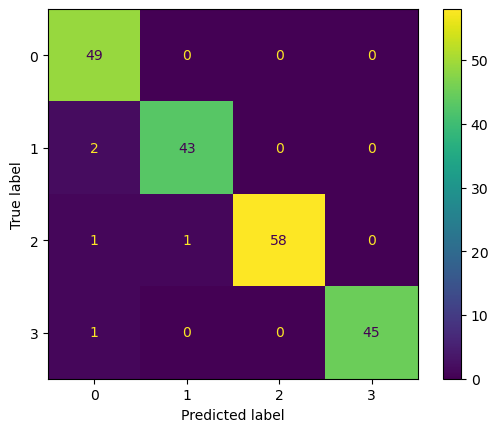

In [199]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste1)
print(classification_report(y_teste, y_pred_teste1))

## Matriz de confusão da segunda parametrização

              precision    recall  f1-score   support

           0       0.51      1.00      0.67        49
           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        60
           3       0.44      0.98      0.60        46

    accuracy                           0.47       200
   macro avg       0.24      0.49      0.32       200
weighted avg       0.22      0.47      0.30       200



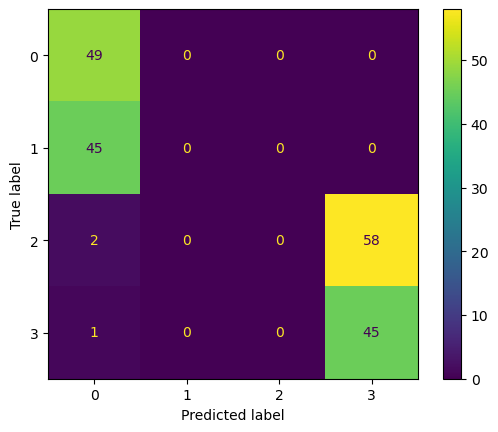

In [200]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste2)
print(classification_report(y_teste, y_pred_teste2))

## Matriz de confusão da terceira parametrização

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        49
           1       0.77      0.82      0.80        45
           2       0.98      0.97      0.97        60
           3       1.00      0.96      0.98        46

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200



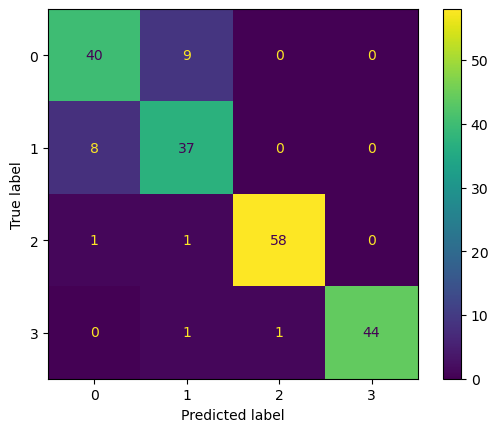

In [201]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_teste3)
print(classification_report(y_teste, y_pred_teste3))

## Viés e Variância

<Figure size 1000x600 with 0 Axes>

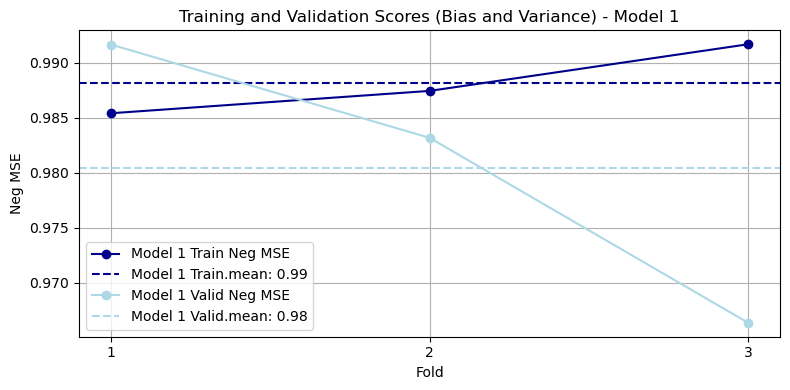

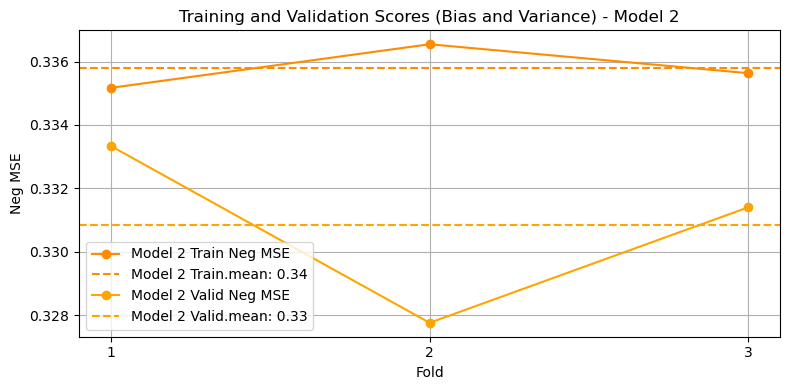

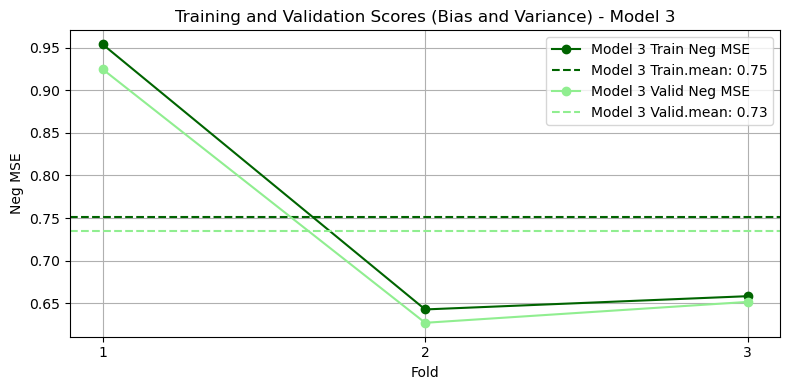

In [202]:
# Exemplo de definição (substitua pelos seus valores reais)
num_params = 3  # Número de conjuntos de parâmetros testados
k_folds = 3     # Número de folds usados na validação cruzada

# Exemplo de listas de scores (substitua pelos seus resultados reais)
# scores_treino = [[...], [...], [...]]
# scores_validos = [[...], [...], [...]]

plt.figure(figsize=(10, 6))
colors = [
    ["darkblue", "lightblue"],
    ["darkorange", "orange"],
    ["darkgreen", "lightgreen"],
]

labels = [f"Model {i+1}" for i in range(num_params)]

for i in range(num_params):
    # Treino
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(scores_treino[i]) + 1), scores_treino[i], label=f"{labels[i]} Train Neg MSE", marker='o', color=colors[i][0])
    plt.axhline(np.mean(scores_treino[i]), color=colors[i][0], linestyle='--', label=f"{labels[i]} Train.mean: {np.mean(scores_treino[i]):.2f}")
    plt.plot(range(1, len(scores_validos[i]) + 1), scores_validos[i], label=f"{labels[i]} Valid Neg MSE", marker='o', color=colors[i][1])
    plt.axhline(np.mean(scores_validos[i]), color=colors[i][1], linestyle='--', label=f"{labels[i]} Valid.mean: {np.mean(scores_validos[i]):.2f}")
    plt.xlabel("Fold")
    plt.ylabel("Neg MSE")
    plt.title(f"Training and Validation Scores (Bias and Variance) - {labels[i]}")
    plt.legend()
    plt.xticks(np.arange(1, k_folds + 1, 1))
    plt.grid()
    plt.tight_layout()
    plt.show()

## Árvores de decisão

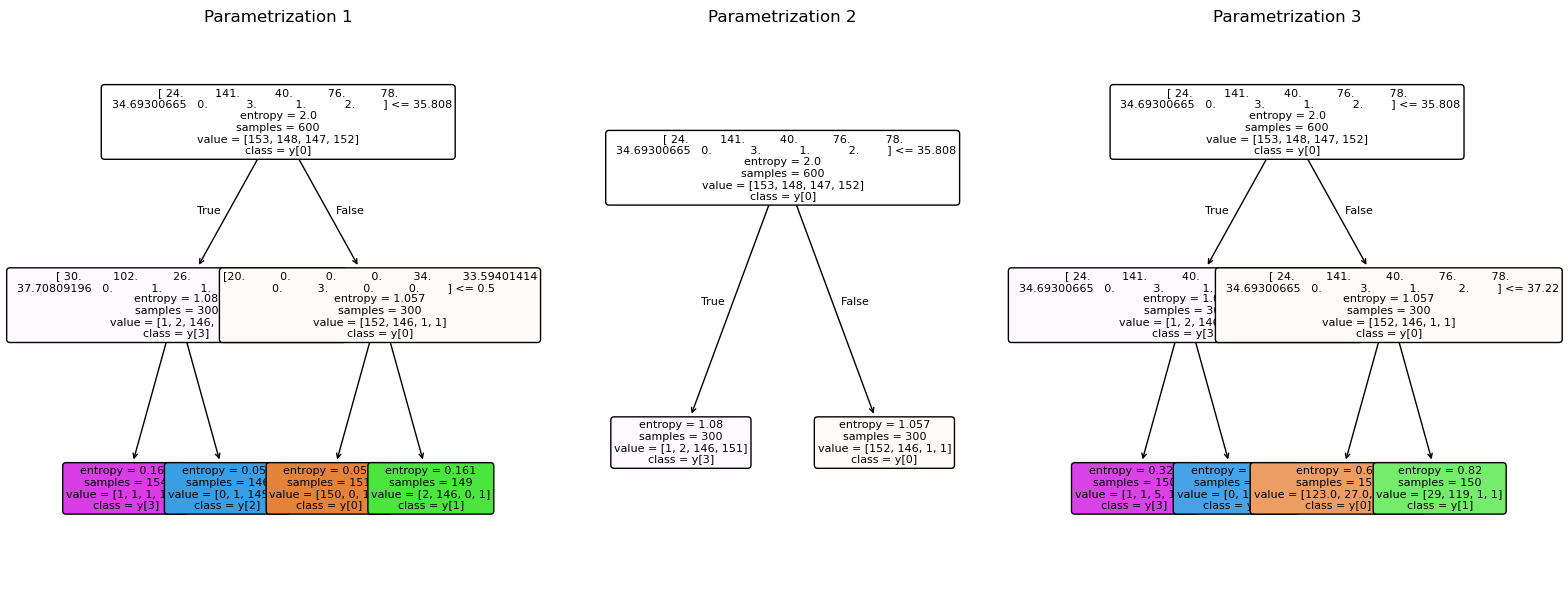

In [203]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

tree.plot_tree(best1,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[0])  # Assign the plot to the correct subplot
axes.flatten()[0].set_title(f"Parametrization {1}")  # Add a title to each subplot
tree.plot_tree(best2,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[1])  # Assign the plot to the correct subplot
axes.flatten()[1].set_title(f"Parametrization {2}")  # Add a title to each subplot
tree.plot_tree(best3,
    feature_names=X,
    filled=True,
    rounded=True,
    class_names=True,
    fontsize=8,
    ax=axes.flatten()[2])  # Assign the plot to the correct subplot
axes.flatten()[2].set_title(f"Parametrization {3}")  # Add a title to each subplot

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Retreinar o modelo

In [204]:
# parâmetros para o grid search
depth = 2
leaf = 0.23
parameters = [
    {'criterion': ['entropy'], 'max_depth': [depth], 'min_samples_leaf': [leaf]}
]

# instantiate model
model = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf = GridSearchCV(model, parameters, cv=5, scoring='f1_macro', verbose=4, return_train_score=True)
clf.fit(X, y)
best = clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.983, test=0.988) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.984, test=0.981) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.981, test=0.994) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=0.23;, score=(train=0.986, test=0.975) total time=   0.0s


## Teste de Predição

In [205]:
df_pred = pd.read_csv('datasets/vict/10v/dataprediction.csv')
print(f"Dataset com {len(df_pred)} vítimas")
print(df_pred.head())
X_pred = df_pred.iloc[:, 0:10].values   # colunas 1 a 10
y_pred = clf.predict(X_pred)
y_true_pred = df_pred["tri"].values          # coluna 13

from sklearn.metrics import accuracy_score

taxa_sucesso = accuracy_score(y_true_pred, y_pred) * 100
print(f"Taxa de sucesso entre y e y_pred: {taxa_sucesso:.2f}%")

Dataset com 1000 vítimas
   idade   fc  fr  pas  spo2       temp  pr  sg  fx  queim  gcs  avpu  tri  \
0      2  105  26   99    98  37.249129   1   1   0      0   12     1    1   
1     46   11   3    3    29  28.146728   0   3   0      3    5     3    3   
2     59  106  29  115    98  38.073368   1   1   0      0   12     1    1   
3     24  158  41   64    78  35.314096   0   3   1      0   10     2    2   
4     32   11   1    0    65  32.876004   0   3   1      3    4     3    3   

   sobr  
0  0.70  
1  0.28  
2  0.74  
3  0.75  
4  0.10  
Taxa de sucesso entre y e y_pred: 89.50%


## Resultados

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       242
           1       0.88      0.94      0.91       243
           2       0.89      0.86      0.87       257
           3       0.89      0.93      0.91       258

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.89      1000
weighted avg       0.90      0.90      0.89      1000



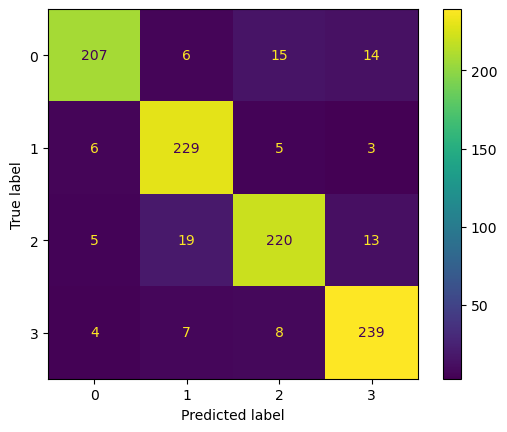

In [206]:
ConfusionMatrixDisplay.from_predictions(y_true_pred, y_pred)
print(classification_report(y_true_pred, y_pred))

In [207]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_pred, y_pred, average='macro')
recall = recall_score(y_true_pred, y_pred, average='macro')
fscore = f1_score(y_true_pred, y_pred, average='macro')

print(f"Precisão (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F-score (macro): {fscore:.4f}")

Precisão (macro): 0.8963
Recall (macro): 0.8950
F-score (macro): 0.8948
